# Проект Временные ряды

## Прогнозирование заказов такси

**Описание проекта**
* Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах.
* Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 
* Постройте модель для такого предсказания.
* Значение метрики **RMSE** на тестовой выборке должно быть не больше **48**.

**План работы**
1. **Подготовка**
2. **Анализ**
3. **Обучение**
4. **Тестирование**
5. **Вывод**

## 1.Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error as mse
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=[0])
except:
    df = pd.read_csv('C:/Users/copok/Documents/Проекты/Яндекс практикум/12. Предсказание такси/taxi.csv',\
                     index_col='datetime', parse_dates=[0])


In [3]:
def get_data_info(data):
    display(data.sample(5))
    print('-'*50)
    display(data.info()) 
    print('-'*50)
    display(data.describe())

In [4]:
get_data_info(df)

,num_orders
datetime,
2018-07-24 12:10:00,19
2018-04-18 18:10:00,4
2018-05-31 10:20:00,12
2018-03-31 04:40:00,11
2018-03-19 01:40:00,23


--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

--------------------------------------------------


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Проверим индекс на монотонность

In [5]:
df.index.is_monotonic_increasing

True

**Данные загрузили. Теперь выполним их ресемплирование по одному часу.**

Поскольку предсказываем количество заказов такси на следующий час, аггрегируем суммы значений.

In [6]:
df = df.sort_index()
df = df.resample('1H').sum()

In [7]:
f"Временной промежуток данных: {df.index.min()} - {df.index.max()}"

'Временной промежуток данных: 2018-03-01 00:00:00 - 2018-08-31 23:00:00'

## 2.Анализ

* **Разложим данные на три составляющие: тренд, сезонность и остаток.**
* Построим графики последнего месяца временного ряда и проанализируем данные.

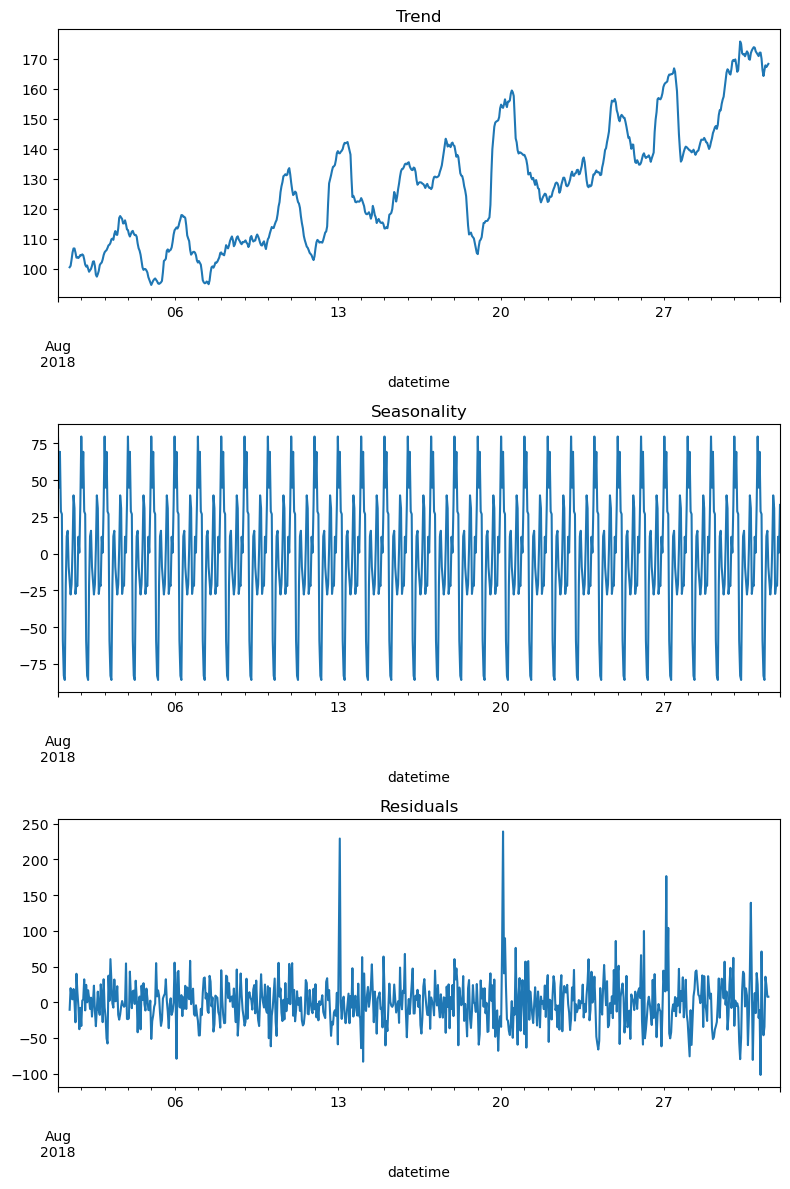

In [8]:
decomposed = seasonal_decompose(df['2018-08':'2018-08'])
plt.figure(figsize=(8, 12))
plt.subplot(311)

# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

* Трэнд показывает линейный рост количества заказов со временем. Построим тренд для всего временного ряда, чтобы увидеть полную картину.
* Распределение сезонной части выглядит статическим в интервале суток. Ночью такси почти не заказывают, пик ближе к вечеру.
* Случайная часть также имеет постоянной среднее значение, но периодически возникают большие всплески (объясняются повышенным спросом на такси по выходным и праздникам)


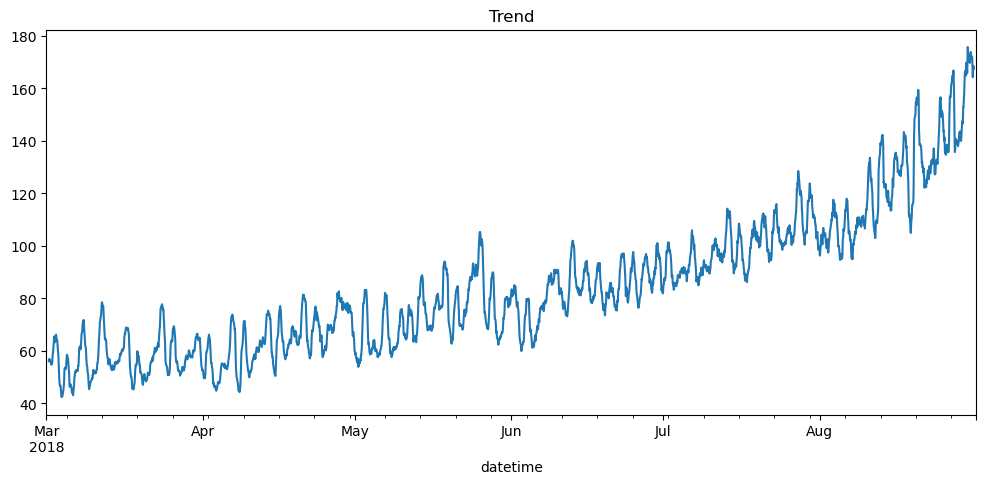

In [9]:
decomposed = seasonal_decompose(df)
plt.figure(figsize=(12, 5))
decomposed.trend.plot()
plt.title('Trend');

* Трэнд имеет более сложную зависимость от времени (квадраичная или экспоненциальная, сложно оценить по днной выборке). Для нашей задачи будем считать его линейным (предсказания нам нужны всего на час вперёд).
* Также заметим, что линия тренда имеет некоторый шум. Возможно, для предсказания будет необходимо применить скользящее среднее с окном в несколько десятков часов.

## 3.Обучение

**В качестве baseline модели будем предсказывать новые значения предыдущими**

In [10]:
train, test = train_test_split(df, shuffle=False, test_size=0.2)
train = train.dropna()
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
rmse_base =  mean_squared_error(test['num_orders'], pred_previous) ** 0.5
print("RMSE baseline модели:", round(rmse_base, 2))

RMSE baseline модели: 53.37


Проверим предсказания по среднему значению

In [11]:
pred_mean = np.ones(test.shape) * train['num_orders'].mean()
print("RMSE baseline модели:", mean_squared_error(test['num_orders'], pred_mean) ** 0.5)

RMSE baseline модели: 74.42015786913375


Предсказания по предыдущему значению показывают лучший результат. Возьмём их в качестве baseline.

**Напишем функцию `make_features` для создания обучающих признаков.** 

In [12]:
#Обучим различные модели и добавим модели и рассчитанный RMSE в массив
train_models = []

In [13]:
def RMSE(target,predictions):
    MSE = mean_squared_error(target, predictions)
    return MSE ** 0.5
RMSE_score = make_scorer(RMSE, greater_is_better=False)

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.dayofweek
    # вычислим отстающие значения
    # добавим новый аргумент max_lag, который задаст максимальный размер отставания. 
    # новые признаки назовем: 'lag_1', 'lag_2' — и до величины max_lag.
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)# 
    # вычислим скользящее среднее и добавим его как признак 'rolling_mean'.
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

In [15]:
# зададим отстающие признаки 20, а скользящее среднее 10
df = make_features(df, 40, 20)

In [16]:
# разделим выборки на обучающую и тестовую
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
 
X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

# проверим размер выборок
display(train.shape)
display(test.shape)
# проверим корректность деления
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

(3934, 46)

(442, 46)

2018-03-02 16:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


### Модель линейной регрессии

In [17]:
%%time
LR_model = LinearRegression()
 
LR_model.fit(X_train, y_train)
train_pred = LR_model.predict(X_train)
LR_rmse = mean_squared_error(y_train, train_pred)**0.5
f"RMSE для линейной модели на обучающей выборке: {round(LR_rmse, 2)}"

CPU times: total: 46.9 ms
Wall time: 20.5 ms


'RMSE для линейной модели на обучающей выборке: 25.04'

### DecisionTree

In [18]:
DT_model = DecisionTreeRegressor(random_state=42)
treeregressor_params = {'max_depth':range (1,10), 'min_samples_split':range(2,6), 'min_samples_leaf':range(1,10)}

In [19]:
%%time
DT_model = GridSearchCV(DT_model , param_grid = treeregressor_params, cv=5,
                                            scoring = RMSE_score, n_jobs=-1)
DT_model.fit(X_train,y_train)
DT_model.best_params_

CPU times: total: 5.64 s
Wall time: 31.4 s


{'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 2}

In [20]:
%%time
DT_train = DecisionTreeRegressor(**DT_model.best_params_).fit(X_train, y_train)

CPU times: total: 93.8 ms
Wall time: 92 ms


In [21]:
%%time
DT_pred = DT_train.predict(X_train)

CPU times: total: 31.2 ms
Wall time: 6.07 ms


In [22]:
DT_rmse = np.sqrt(mse(y_train, DT_pred))
f"RMSE для DecisionTreeRegressor на обучающей выборке: {round(DT_rmse, 2)}"

'RMSE для DecisionTreeRegressor на обучающей выборке: 25.38'

### CatBoost

In [23]:
catboost_params = {
    'learning_rate': [0.1],
    'iterations': [50, 100, 200],
    'max_depth': [2, 4, 6]
}
catboost_model = CatBoostRegressor(random_state=42,silent=True)

In [24]:
%%time
cat_model = GridSearchCV(catboost_model, param_grid = catboost_params, cv = 5, n_jobs=-1, scoring=RMSE_score)\
                                                                                         .fit(X_train, y_train)

cat_model.best_params_

CPU times: total: 8.06 s
Wall time: 16.3 s


{'iterations': 200, 'learning_rate': 0.1, 'max_depth': 6}

In [25]:
%%time
cat_train = CatBoostRegressor(**cat_model.best_params_,  logging_level='Silent').fit(X_train, y_train)

CPU times: total: 7.78 s
Wall time: 1.22 s


In [26]:
%%time
cat_pred = cat_train.predict(X_train)

CPU times: total: 0 ns
Wall time: 5.05 ms


In [27]:
cat_rmse = np.sqrt(mse(y_train,cat_pred))
f"RMSE для CatBoostRegressor на обучающей выборке: {round(cat_rmse, 2)}"

'RMSE для CatBoostRegressor на обучающей выборке: 16.22'

In [28]:
model = pd.DataFrame([['Baseline', round(rmse_base, 2)],
                      ['Linear Regression', round(LR_rmse, 2)],
                      ['DecisionTree', round(DT_rmse, 2)],
                      ['CatBoost', round(cat_rmse, 2)]],
                    columns = ['model', 'RMSE'])

In [29]:
model.sort_values('RMSE')

,model,RMSE
3,CatBoost,16.22
1,Linear Regression,25.04
2,DecisionTree,25.38
0,Baseline,53.37


## 4.Тестирование

In [30]:
%%time
test_cat_pred = cat_train.predict(X_test)

CPU times: total: 0 ns
Wall time: 5.97 ms


In [31]:
test_cat_rmse = np.sqrt(mse(y_test,test_cat_pred))
f"RMSE для CatBoostRegressor тестовой выборке: {round(test_cat_rmse , 2)}"

'RMSE для CatBoostRegressor тестовой выборке: 42.68'

## 5.Вывод

* Загрузили данные
* Выполним  ресемплирование по одному часу.
* При анализе данных разложили данные на три составляющие: тренд, сезонность и остаток.
  * Трэнд показывает линейный рост количества заказов со временем. Построим тренд для всего временного ряда, чтобы увидеть полную картину.
    * Трэнд имеет более сложную зависимость от времени (квадраичная или экспоненциальная, сложно оценить по днной выборке). Для нашей задачи будем считать его линейным (предсказания нам нужны всего на час вперёд).
    * Также заметим, что линия тренда имеет некоторый шум. Возможно, для предсказания будет необходимо применить скользящее среднее с окном в несколько десятков часов.
  * Распределение сезонной части выглядит статическим в интервале суток. Ночью такси почти не заказывают, пик ближе к вечеру.
  * Случайная часть также имеет постоянной среднее значение, но периодически возникают большие всплески (объясняются повышенным спросом на такси по выходным и праздникам)
  

* Написали функцию **`make_features`** для создания обучающих признаков. 
* Подобрали гиперпараметры и обучили несколько разных моделей.
* Лучший результат показала модель **`CatBoost`**
* Протестировали выборку на этой модели 


* Получили значение **`RMSE`** **42.68**, что соответствует условию задачи.

